# SEMANTIC ANALYSIS USING AMAZON REVIEWS DATASET

   # IMPORTING LIBRARIES

In [104]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.1 MB/s eta 0:00:00


In [93]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
# import matplotlib.pyplot as plt
import nltk

# DATASET EXPLORATION

In [4]:
# Load the original dataset
df = pd.read_csv('amazon_reviews.csv')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4915 non-null   int64  
 1   reviewerName          4914 non-null   object 
 2   overall               4915 non-null   float64
 3   reviewText            4914 non-null   object 
 4   reviewTime            4915 non-null   object 
 5   day_diff              4915 non-null   int64  
 6   helpful_yes           4915 non-null   int64  
 7   helpful_no            4915 non-null   int64  
 8   total_vote            4915 non-null   int64  
 9   score_pos_neg_diff    4915 non-null   int64  
 10  score_average_rating  4915 non-null   float64
 11  wilson_lower_bound    4915 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 460.9+ KB


In [6]:
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


In [7]:
df.isnull().sum()

Unnamed: 0              0
reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64

# **EDA**

In [8]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

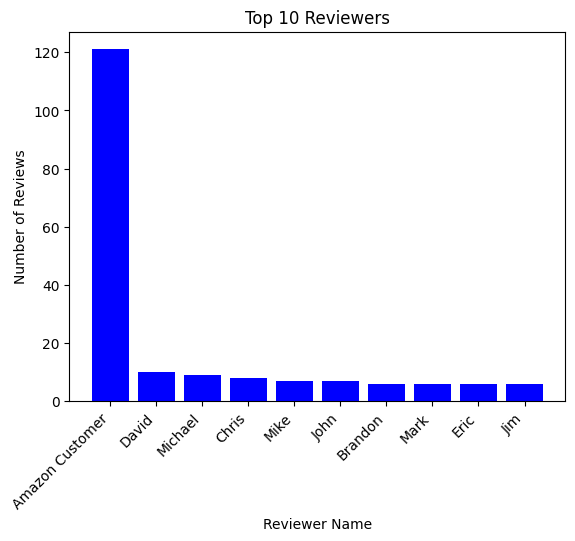

In [10]:
# Reviewer Analysis
reviewer_counts = df['reviewerName'].value_counts().head(10)
plt.bar(reviewer_counts.index, reviewer_counts.values, color='blue')
plt.title('Top 10 Reviewers')
plt.xlabel('Reviewer Name')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.show()

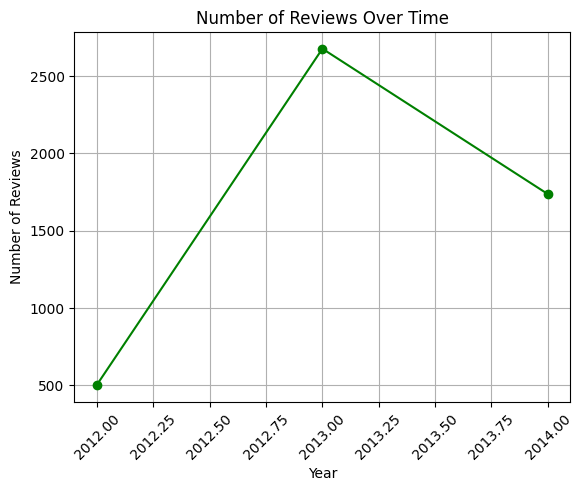

In [11]:
# Review Time Analysis
df['reviewTime'] = pd.to_datetime(df['reviewTime'])
df['reviewYear'] = df['reviewTime'].dt.year
review_year_counts = df['reviewYear'].value_counts().sort_index()
plt.plot(review_year_counts.index, review_year_counts.values, marker='o', color='green')
plt.title('Number of Reviews Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

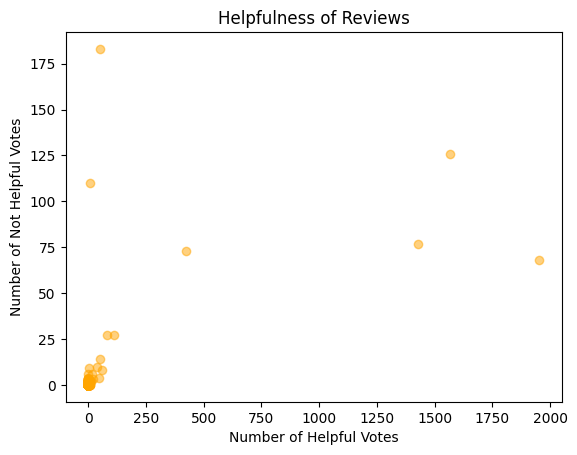

In [12]:
# Helpfulness Analysis
plt.scatter(df['helpful_yes'], df['helpful_no'], color='orange', alpha=0.5)
plt.title('Helpfulness of Reviews')
plt.xlabel('Number of Helpful Votes')
plt.ylabel('Number of Not Helpful Votes')
plt.show()

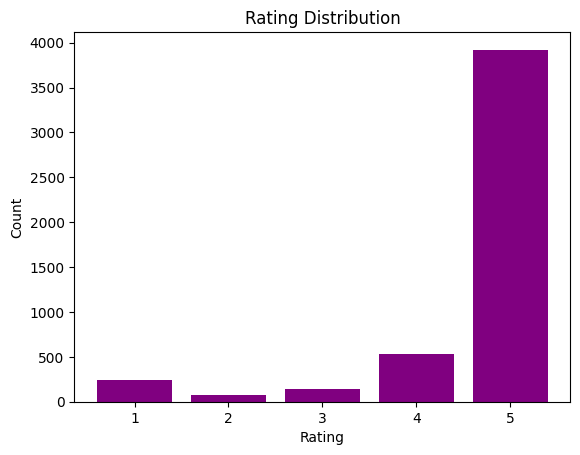

In [14]:
# Rating Distribution
rating_counts = df['overall'].value_counts().sort_index()
plt.bar(rating_counts.index, rating_counts.values, color='purple')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(np.arange(1, 6))
plt.show()


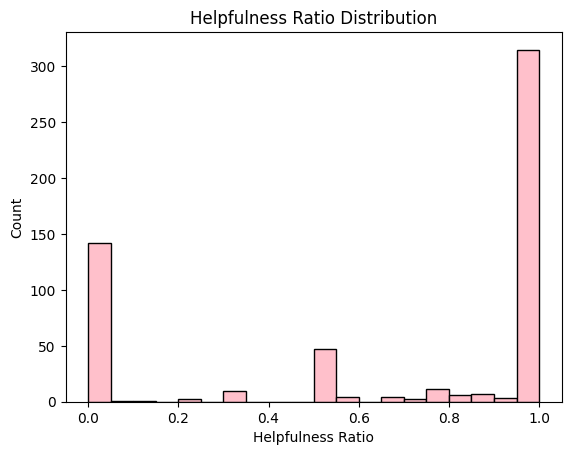

In [15]:
# Helpfulness Ratio
df['helpfulness_ratio'] = df['helpful_yes'] / (df['helpful_yes'] + df['helpful_no'])
plt.hist(df['helpfulness_ratio'].dropna(), bins=20, color='pink', edgecolor='black')
plt.title('Helpfulness Ratio Distribution')
plt.xlabel('Helpfulness Ratio')
plt.ylabel('Count')
plt.show()

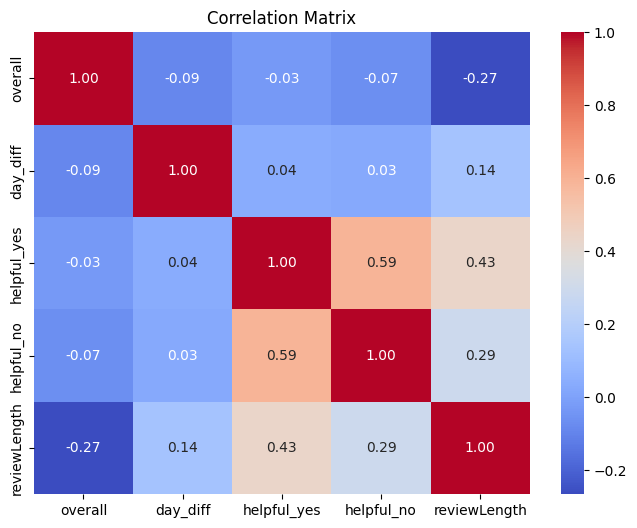

In [20]:
# Calculate the length of each review text
df['reviewLength'] = df['reviewText'].apply(lambda x: len(str(x).split()))

# Correlation Analysis
correlation_cols = ['overall', 'day_diff', 'helpful_yes', 'helpful_no', 'reviewLength']
correlation_matrix = df[correlation_cols].corr()

# Plotting the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

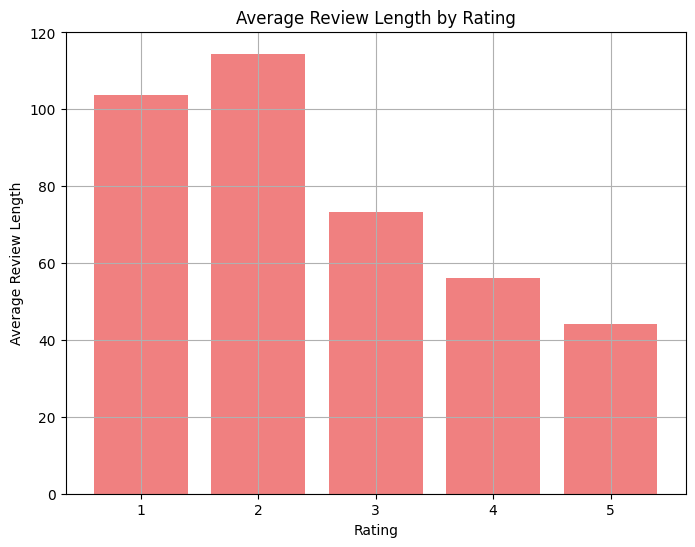

In [23]:
# Barplot of Average Review Length by Rating
average_review_length = df.groupby('overall')['reviewLength'].mean()
plt.figure(figsize=(8, 6))
plt.bar(average_review_length.index, average_review_length.values, color='lightcoral')
plt.title('Average Review Length by Rating')
plt.xlabel('Rating')
plt.ylabel('Average Review Length')
plt.xticks(np.arange(1, 6))
plt.grid(True)
plt.show()

# PREPROCESSING

In [32]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [37]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [38]:
# Keep only relevant columns
df = df[['reviewText', 'overall']]


In [39]:
# Preprocess text
stop_words = set(stopwords.words('english'))

In [40]:
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    # Join tokens back to text
    return ' '.join(tokens)


In [41]:
# Apply preprocessing to reviewText
df['cleaned_reviewText'] = df['reviewText'].apply(lambda x: preprocess_text(x) if pd.notnull(x) else '')


In [42]:
# Replace NaN values with empty strings in the cleaned_reviewText column
df['cleaned_reviewText'] = df['cleaned_reviewText'].fillna('')

In [43]:
# Create sentiment column
def label_sentiment(rating):
    if rating in [1, 2]:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

In [44]:
df['sentiment'] = df['overall'].apply(label_sentiment)

In [45]:
# Save the preprocessed data to a new CSV file
df[['cleaned_reviewText', 'sentiment']].to_csv('preprocessed_amazon_reviews.csv', index=False)

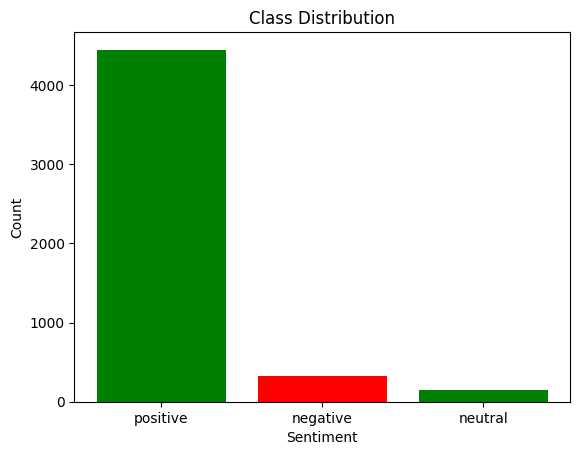

In [46]:
df['sentiment'] = df['overall'].map({1: 'negative', 2: 'negative', 3: 'neutral', 4: 'positive', 5: 'positive'})
sentiment_counts = df['sentiment'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red'])
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# LEXIC AUGMENTATION

In [52]:
# Read negative words from file with 'ISO-8859-1' encoding
with open('negative-words.txt', 'r', encoding='ISO-8859-1') as file:
    negative_words = file.read().splitlines()


In [55]:
# Initialize an empty list to store dictionaries
negative_augmented_data = []

# Loop through negative words and append to the list
for word in negative_words:
    # Exclude "this product" from negative words
    if "this product" not in word:
        negative_augmented_data.append({'cleaned_reviewText': word, 'sentiment': 'negative'})

# Convert the list of dictionaries to a DataFrame
df_negative_augmented = pd.concat([df_negative_augmented, pd.DataFrame(negative_augmented_data)], ignore_index=True)


In [56]:
# Concatenate the original and augmented data
df_augmented = pd.concat([df[['cleaned_reviewText', 'sentiment']], df_negative_augmented])

In [57]:
# Save the augmented data to a new CSV file
df_augmented.to_csv('augmented_amazon_reviews.csv', index=False)

In [58]:
# Load the augmented data
df_augmented = pd.read_csv('augmented_amazon_reviews.csv')


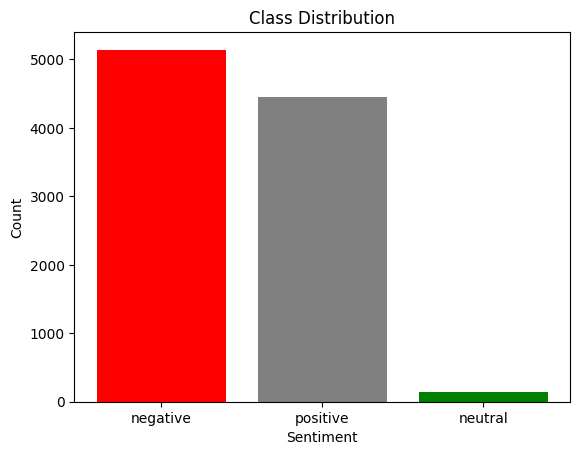

In [59]:
# Visualize class distribution
sentiment_counts = df_augmented['sentiment'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['red', 'grey', 'green'])
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# DATA PREPARATION

In [60]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df_augmented['cleaned_reviewText'],
    df_augmented['sentiment'],
    test_size=0.2,
    random_state=42
)


In [61]:
# Tokenize the text
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_augmented['cleaned_reviewText'].fillna('').astype(str))  # Replace NaN with empty string
X_train_seq = tokenizer.texts_to_sequences(X_train.fillna('').astype(str))  # Replace NaN with empty string
X_test_seq = tokenizer.texts_to_sequences(X_test.fillna('').astype(str))  # Replace NaN with empty string


In [62]:
import joblib
joblib.dump(tokenizer, "tk2.pkl")
model=joblib.load('tk2.pkl')


In [63]:
# Pad sequences for equal length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


In [64]:
# Convert sentiment labels to numeric
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


In [65]:
import joblib
joblib.dump(le, "le2.pkl")
model=joblib.load('le2.pkl')

In [67]:
import pickle
with open('labelEncoder.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


# 1D CNN --- LSTM --- BIDIRECTIONAL LSTM MODELS

In [68]:
# Build and train the 1D CNN model
model_cnn = Sequential()
model_cnn.add(Embedding(max_words, 64, input_length=max_len))
model_cnn.add(Conv1D(128, 5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(3, activation='softmax'))
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_cnn.fit(X_train_pad, y_train_encoded, epochs=10, validation_split=0.2)


Epoch 1/10
195/195 [==============================] - 9s 38ms/step - loss: 0.3201 - accuracy: 0.9127 - val_loss: 0.2033 - val_accuracy: 0.9448
Epoch 2/10
195/195 [==============================] - 6s 32ms/step - loss: 0.1444 - accuracy: 0.9584 - val_loss: 0.1788 - val_accuracy: 0.9506
Epoch 3/10
195/195 [==============================] - 8s 39ms/step - loss: 0.0854 - accuracy: 0.9758 - val_loss: 0.1714 - val_accuracy: 0.9538
Epoch 4/10
195/195 [==============================] - 6s 31ms/step - loss: 0.0504 - accuracy: 0.9844 - val_loss: 0.1852 - val_accuracy: 0.9525
Epoch 5/10
195/195 [==============================] - 8s 41ms/step - loss: 0.0290 - accuracy: 0.9928 - val_loss: 0.1978 - val_accuracy: 0.9544
Epoch 6/10
195/195 [==============================] - 6s 30ms/step - loss: 0.0170 - accuracy: 0.9966 - val_loss: 0.2215 - val_accuracy: 0.9538
Epoch 7/10
195/195 [==============================] - 8s 41ms/step - loss: 0.0097 - accuracy: 0.9986 - val_loss: 0.2469 - val_accuracy: 0.9487

In [69]:
# Build and train the LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(max_words, 64, input_length=max_len))
model_lstm.add(LSTM(128))
model_lstm.add(Dense(3, activation='softmax'))
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_lstm.fit(X_train_pad, y_train_encoded, epochs=10, validation_split=0.2)



Epoch 1/10
195/195 [==============================] - 38s 183ms/step - loss: 0.2600 - accuracy: 0.9207 - val_loss: 0.1698 - val_accuracy: 0.9442
Epoch 2/10
195/195 [==============================] - 34s 173ms/step - loss: 0.1144 - accuracy: 0.9660 - val_loss: 0.1787 - val_accuracy: 0.9474
Epoch 3/10
195/195 [==============================] - 36s 186ms/step - loss: 0.0729 - accuracy: 0.9770 - val_loss: 0.2155 - val_accuracy: 0.9506
Epoch 4/10
195/195 [==============================] - 33s 171ms/step - loss: 0.0509 - accuracy: 0.9846 - val_loss: 0.2119 - val_accuracy: 0.9422
Epoch 5/10
195/195 [==============================] - 34s 172ms/step - loss: 0.0299 - accuracy: 0.9921 - val_loss: 0.2342 - val_accuracy: 0.9442
Epoch 6/10
195/195 [==============================] - 36s 182ms/step - loss: 0.0173 - accuracy: 0.9957 - val_loss: 0.2583 - val_accuracy: 0.9435
Epoch 7/10
195/195 [==============================] - 34s 173ms/step - loss: 0.0202 - accuracy: 0.9942 - val_loss: 0.2678 - val_ac

In [70]:
# Build and train the Bidirectional LSTM model
model_bidirectional_lstm = Sequential()
model_bidirectional_lstm.add(Embedding(max_words, 64, input_length=max_len))
model_bidirectional_lstm.add(Bidirectional(LSTM(64)))
model_bidirectional_lstm.add(Dense(3, activation='softmax'))
model_bidirectional_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_bidirectional_lstm.fit(X_train_pad, y_train_encoded, epochs=10, validation_split=0.2)


Epoch 1/10
195/195 [==============================] - 31s 133ms/step - loss: 0.2650 - accuracy: 0.9229 - val_loss: 0.1725 - val_accuracy: 0.9442
Epoch 2/10
195/195 [==============================] - 24s 122ms/step - loss: 0.1150 - accuracy: 0.9663 - val_loss: 0.1749 - val_accuracy: 0.9454
Epoch 3/10
195/195 [==============================] - 26s 132ms/step - loss: 0.0783 - accuracy: 0.9772 - val_loss: 0.1999 - val_accuracy: 0.9390
Epoch 4/10
195/195 [==============================] - 25s 131ms/step - loss: 0.0497 - accuracy: 0.9838 - val_loss: 0.2536 - val_accuracy: 0.9474
Epoch 5/10
195/195 [==============================] - 24s 121ms/step - loss: 0.0339 - accuracy: 0.9896 - val_loss: 0.2431 - val_accuracy: 0.9384
Epoch 6/10
195/195 [==============================] - 26s 131ms/step - loss: 0.0194 - accuracy: 0.9949 - val_loss: 0.2824 - val_accuracy: 0.9300
Epoch 7/10
195/195 [==============================] - 26s 131ms/step - loss: 0.0101 - accuracy: 0.9982 - val_loss: 0.3015 - val_ac

# EVALUATION METRICS AND COMPARISON


In [71]:
# Evaluate models
def evaluate_model(model, X_test_pad, y_test_encoded):
    y_pred = np.argmax(model.predict(X_test_pad), axis=1)
    accuracy = np.sum(y_pred == y_test_encoded) / len(y_test_encoded)
    print(classification_report(y_test_encoded, y_pred))
    print(confusion_matrix(y_test_encoded, y_pred))
    return accuracy

In [72]:
print("1D CNN Model Evaluation:")
evaluate_model(model_cnn, X_test_pad, y_test_encoded)

1D CNN Model Evaluation:
61/61 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       991
           1       0.00      0.00      0.00        29
           2       0.95      0.98      0.97       927

    accuracy                           0.96      1947
   macro avg       0.64      0.65      0.65      1947
weighted avg       0.95      0.96      0.96      1947

[[956   8  27]
 [  5   0  24]
 [  9   5 913]]


0.9599383667180277

In [73]:
print("\nLSTM Model Evaluation:")
evaluate_model(model_lstm, X_test_pad, y_test_encoded)


LSTM Model Evaluation:
61/61 [==============================] - 5s 62ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       991
           1       0.04      0.03      0.04        29
           2       0.94      0.97      0.95       927

    accuracy                           0.95      1947
   macro avg       0.65      0.65      0.65      1947
weighted avg       0.95      0.95      0.95      1947

[[949   5  37]
 [  4   1  24]
 [ 13  17 897]]


0.9486389316897792

In [74]:
print("\nBidirectional LSTM Model Evaluation:")
evaluate_model(model_bidirectional_lstm, X_test_pad, y_test_encoded)


Bidirectional LSTM Model Evaluation:
61/61 [==============================] - 2s 27ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       991
           1       0.12      0.14      0.13        29
           2       0.94      0.96      0.95       927

    accuracy                           0.95      1947
   macro avg       0.68      0.69      0.69      1947
weighted avg       0.95      0.95      0.95      1947

[[952   9  30]
 [  2   4  23]
 [ 16  19 892]]


0.9491525423728814

In [75]:
# Evaluate models
accuracy_cnn = evaluate_model(model_cnn, X_test_pad, y_test_encoded)
accuracy_lstm = evaluate_model(model_lstm, X_test_pad, y_test_encoded)
accuracy_bidirectional_lstm = evaluate_model(model_bidirectional_lstm, X_test_pad, y_test_encoded)

61/61 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       991
           1       0.00      0.00      0.00        29
           2       0.95      0.98      0.97       927

    accuracy                           0.96      1947
   macro avg       0.64      0.65      0.65      1947
weighted avg       0.95      0.96      0.96      1947

[[956   8  27]
 [  5   0  24]
 [  9   5 913]]
61/61 [==============================] - 5s 81ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       991
           1       0.04      0.03      0.04        29
           2       0.94      0.97      0.95       927

    accuracy                           0.95      1947
   macro avg       0.65      0.65      0.65      1947
weighted avg       0.95      0.95      0.95      1947

[[949   5  37]
 [  4   1  24]
 [ 13  17 897]]
61/61 [==============================] 

In [76]:
best_model = max([
    ("1D CNN", accuracy_cnn),
    ("LSTM", accuracy_lstm),
    ("Bidirectional LSTM", accuracy_bidirectional_lstm)
], key=lambda x: x[1])

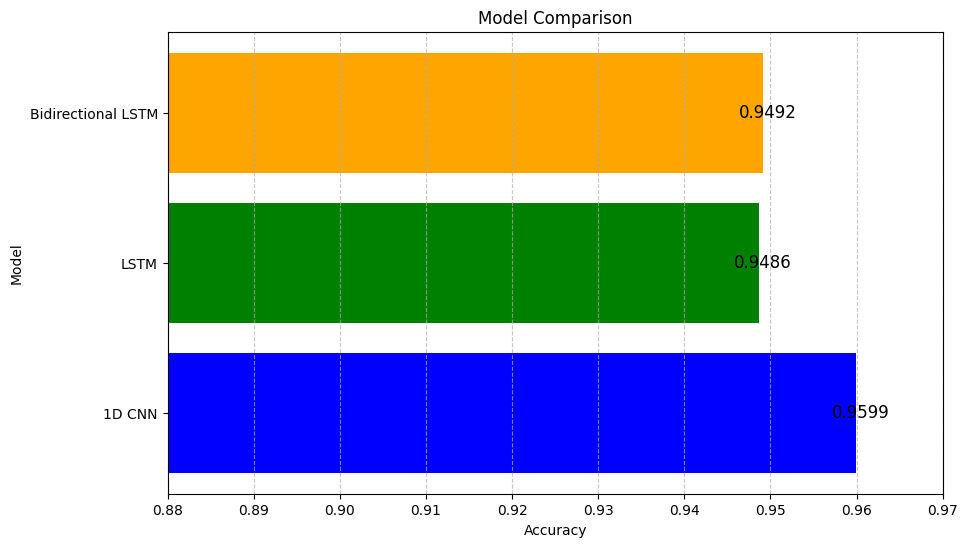

In [102]:
import matplotlib.pyplot as plt

# Accuracy of each model
accuracies = [accuracy_cnn, accuracy_lstm, accuracy_bidirectional_lstm]
models = ['1D CNN', 'LSTM', 'Bidirectional LSTM']
# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(models, accuracies, color=['blue', 'green', 'orange'])
# Add text annotations to display the accuracy on each bar with four decimal places
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_width() + 0.0005, bar.get_y() + bar.get_height() / 2,
             f'{accuracy:.4f}', ha='center', va='center', color='black', fontsize=12)

plt.title('Model Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.xlim(0.88, 0.97)  # Adjust x-axis limit to show differences more clearly
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

In [77]:
print(f"\nThe best model is {best_model[0]} with an accuracy of {best_model[1]:.2%}.")


The best model is 1D CNN with an accuracy of 95.99%.


In [106]:
# Early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def build_cnn_model(hp):
    model = Sequential()
    model.add(Embedding(max_words, hp.Choice('embedding_dim', [32, 64, 128]), input_length=max_len))
    model.add(Conv1D(hp.Choice('filters', [32, 64, 128]), hp.Choice('kernel_size', [3, 5]), activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

tuner_cnn = kt.Hyperband(
    build_cnn_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='cnn_tuning'
)

tuner_cnn.search(X_train_pad, y_train_encoded, epochs=5, validation_split=0.2, callbacks=[early_stopping])
best_cnn_model = tuner_cnn.get_best_models(num_models=1)[0]
best_cnn_model.summary()

Trial 60 Complete [00h 00m 29s]
val_accuracy: 0.9512194991111755

Best val_accuracy So Far: 0.9576380252838135
Total elapsed time: 00h 33m 46s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 96, 32)            20512     
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 1300611 (4.96 MB)
Trainable params: 1300611 (4.96 MB)
Non-trainable params: 0 (0.00 Byte)
_______

In [107]:
def build_lstm_model(hp):
    model = Sequential()
    model.add(Embedding(max_words, hp.Int('embedding_dim', min_value=32, max_value=128, step=32), input_length=max_len))
    model.add(LSTM(hp.Int('units', min_value=32, max_value=128, step=32)))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

tuner_lstm = kt.Hyperband(
    build_lstm_model,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='lstm_tuning'
)

tuner_lstm.search(X_train_pad, y_train_encoded, epochs=10, validation_split=0.2)
best_lstm_model = tuner_lstm.get_best_models(num_models=1)[0]

best_lstm_model.summary()

Trial 22 Complete [00h 03m 09s]
val_accuracy: 0.9505776762962341

Best val_accuracy So Far: 0.9518613815307617
Total elapsed time: 00h 29m 05s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 673219 (2.57 MB)
Trainable params: 673219 (2.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [108]:
from tensorflow.keras.layers import Bidirectional

def build_bidirectional_lstm_model(hp):
    model = Sequential()
    model.add(Embedding(max_words, hp.Int('embedding_dim', min_value=32, max_value=128, step=32), input_length=max_len))
    model.add(Bidirectional(LSTM(hp.Int('units', min_value=32, max_value=128, step=32))))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

tuner_bidirectional_lstm = kt.Hyperband(
    build_bidirectional_lstm_model,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='bidirectional_lstm_tuning'
)

tuner_bidirectional_lstm.search(X_train_pad, y_train_encoded, epochs=10, validation_split=0.2)
best_bidirectional_lstm_model = tuner_bidirectional_lstm.get_best_models(num_models=1)[0]

best_bidirectional_lstm_model.summary()


Trial 22 Complete [00h 04m 27s]
val_accuracy: 0.948010265827179

Best val_accuracy So Far: 0.9525032043457031
Total elapsed time: 00h 44m 03s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           320000    
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 336835 (1.28 MB)
Trainable params: 336835 (1.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [109]:
# Evaluate models
def evaluate_model(model, X_test_pad, y_test_encoded):
    y_pred = np.argmax(model.predict(X_test_pad), axis=1)
    accuracy = np.sum(y_pred == y_test_encoded) / len(y_test_encoded)
    print(classification_report(y_test_encoded, y_pred))
    print(confusion_matrix(y_test_encoded, y_pred))
    return accuracy

print("Best 1D CNN Model Evaluation:")
accuracy_cnn = evaluate_model(best_cnn_model, X_test_pad, y_test_encoded)

print("\nBest LSTM Model Evaluation:")
accuracy_lstm = evaluate_model(best_lstm_model, X_test_pad, y_test_encoded)

print("\nBest Bidirectional LSTM Model Evaluation:")
accuracy_bidirectional_lstm = evaluate_model(best_bidirectional_lstm_model, X_test_pad, y_test_encoded)


Best 1D CNN Model Evaluation:
61/61 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       991
           1       0.33      0.03      0.06        29
           2       0.95      0.99      0.97       927

    accuracy                           0.97      1947
   macro avg       0.76      0.66      0.67      1947
weighted avg       0.96      0.97      0.96      1947

[[962   2  27]
 [  6   1  22]
 [ 11   0 916]]

Best LSTM Model Evaluation:
61/61 [==============================] - 2s 18ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       991
           1       0.00      0.00      0.00        29
           2       0.94      0.98      0.96       927

    accuracy                           0.96      1947
   macro avg       0.64      0.65      0.64      1947
weighted avg       0.94      0.96      0.95      1947

[[953   1  37]
 [  3   0  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [111]:

best_model = max([
    ("1D CNN", accuracy_cnn),
    ("LSTM", accuracy_lstm),
    ("Bidirectional LSTM", accuracy_bidirectional_lstm)
], key=lambda x: x[1])

print(f"\nThe best model is {best_model[0]} with an accuracy of {best_model[1]:.2%}.")


The best model is 1D CNN with an accuracy of 96.51%.


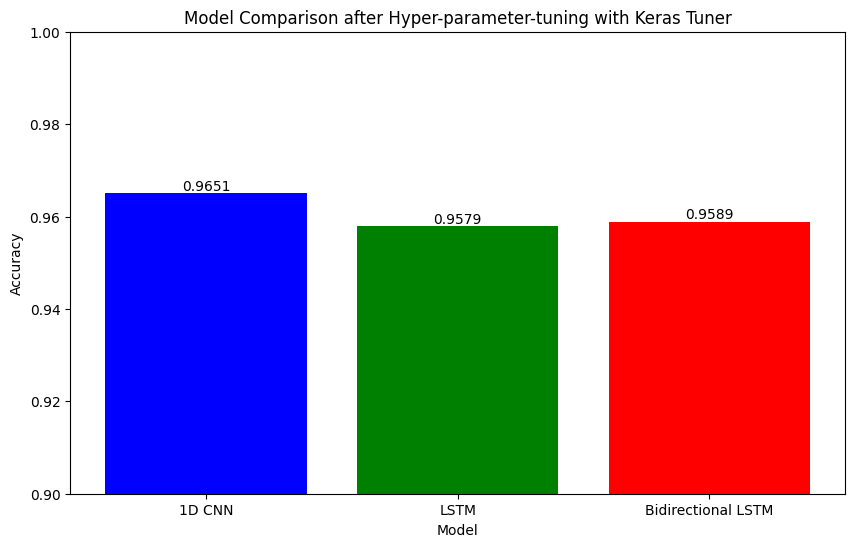

In [113]:
# Visualization
models = ['1D CNN', 'LSTM', 'Bidirectional LSTM']
accuracies = [accuracy_cnn, accuracy_lstm, accuracy_bidirectional_lstm]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison after Hyper-parameter-tuning with Keras Tuner')
plt.ylim(0.90, 1.00)  # Set y-axis limits to better show differences in accuracy
for i, v in enumerate(accuracies):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom')
plt.show()

# CNN MODEL TESTING

In [78]:
custom_comment = " this product doesnt work as expected"
custom_comment_seq = tokenizer.texts_to_sequences([custom_comment])
custom_comment_pad = pad_sequences(custom_comment_seq, maxlen=max_len)
prediction = model_cnn.predict(custom_comment_pad)


1/1 [==============================] - 0s 32ms/step


In [79]:
predicted_sentiment = le.classes_[np.argmax(prediction)]
print(f'Predicted Sentiment: {predicted_sentiment}')

Predicted Sentiment: negative


In [80]:
model_cnn.save('model_CNN.keras')

In [81]:
import joblib
joblib.dump(model_cnn, "cnnv2.pkl")
model=joblib.load('cnnv2.pkl')


In [82]:
custom_comment = " this product doesnt work properly"
custom_comment_seq = tokenizer.texts_to_sequences([custom_comment])
custom_comment_pad = pad_sequences(custom_comment_seq, maxlen=max_len)
prediction = model.predict(custom_comment_pad)

1/1 [==============================] - 0s 71ms/step


In [83]:
predicted_sentiment = le.classes_[np.argmax(prediction)]
print(f'Predicted Sentiment: {predicted_sentiment}')

Predicted Sentiment: negative


In [87]:
model=joblib.load('cnnv2.pkl')
